# 1. NLP

## NLP Class Setting

In [1]:
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction import _stop_words
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.decomposition import TruncatedSVD
import gensim
from gensim import corpora


nltk_stopwords = set(stopwords.words('english'))
sklearn_stopwords = set(_stop_words.ENGLISH_STOP_WORDS)
my_stopwords = nltk_stopwords.union(sklearn_stopwords)
ps = PorterStemmer()
lem = WordNetLemmatizer()

## you can tag the 'part of speech' with this to the word
def get_pos(w):
    tag = pos_tag([w])[0][1][0].upper()
    if tag == 'V':
        return wordnet.VERB
    elif tag == 'N':
        return wordnet.NOUN
    elif tag == 'J':
        return wordnet.ADJ
    elif tag == 'R':
        return wordnet.ADV
    else:
        return wordnet.NOUN

## Stemming based word tokenizer
def token_ws(r):
    r1 = word_tokenize(r)
    r2 = [w.lower() for w in r1 if w.isalpha()]
    r3 = [w for w in r2 if not w in my_stopwords]
    r4 = [ps.stem(w) for w in r3]
    return r4
  
##Lemmatizing based word tokenizer
def token_wl(r):
    r1 = word_tokenize(r)
    r2 = [w.lower() for w in r1 if w.isalpha()]
    r3 = [w for w in r2 if not w in my_stopwords]
    r4 = [lem.lemmatize(w, get_pos(w)) for w in r3]
    return r4


## Natural language processor
class Nlp:
    ## you can input texts in the form of list but if you input a string data, it will automatically transform it into the form of list
    def __init__(self, texts):
        if (type(texts) != list):
            texts = [texts]
        self.texts = texts      

    ## Vectorizer : Choose which word tokenizer you'll use by typing 's' or 'l'. Choose the vectorizing tool by 'count' or 'tfidf'
    def Vectorizer(self, tokenizer, vec):
        if tokenizer == 'l':
            my_tokenizer = token_wl
        else:
            my_tokenizer = token_ws
        
        if vec == 'count':
            vectoring = CountVectorizer(tokenizer=my_tokenizer)
        elif vec == 'tfidf':
            vectoring = TfidfVectorizer(tokenizer=my_tokenizer)
            
        vec_reviews = vectoring.fit_transform(self.texts)
        vec_terms = vectoring.get_feature_names()
        vec_df = pd.DataFrame(vec_reviews.toarray(), columns=vec_terms)
        
        return vec_df
        
    ## Cosine similarity. you can input the same things you input in the Vectorizer
    def Cos_sim(self, tokenizer, vec):
        if tokenizer == 'l':
            my_tokenizer = token_wl
        else:
            my_tokenizer = token_ws
    
        if vec == 'count':
            vectoring = CountVectorizer(tokenizer=my_tokenizer)
        elif vec == 'tfidf':
            vectoring = TfidfVectorizer(tokenizer=my_tokenizer)
            
        vec_reviews = vectoring.fit_transform(self.texts)
        
        ## After going through the preprocessing, this visualize the similarity with Heatmap plot
        sim = cosine_similarity(vec_reviews)
        plt.figure(figsize=(8,8))
        sns.heatmap(sim, vmin = 0, vmax = 1, center = 0, cmap='PiYG', annot = True)
        plt.show()
    

    ## This performs clustering of your text data. you input the tokenizer and the vectorizing tool
    def Cluster(self, tokenizer, vec):
        if tokenizer == 'l':
            my_tokenizer = token_wl
        else:
            my_tokenizer = token_ws
    
        if vec == 'count':
            vectoring = CountVectorizer(tokenizer=my_tokenizer)
        elif vec == 'tfidf':
            vectoring = TfidfVectorizer(tokenizer=my_tokenizer)
            
        vec_reviews = vectoring.fit_transform(self.texts)
        vec_terms = vectoring.get_feature_names()
        vec_df = pd.DataFrame(vec_reviews.toarray(), columns=vec_terms)
        
        ## Here we go through the 'Elbow method' and will show you the graph of it
        distance = []
        K = range(1, 5)
        for k in K:
            km1 = KMeans(n_clusters=k, random_state=0)
            km2 = km1.fit(vec_reviews)
            d = km2.inertia_
            distance.append(d)
        
        plt.figure(figsize=(10,8))
        plt.plot(K, distance)
        plt.show()
        
        ## After showing the graph of 'Elbow method', you should input the number of cluster you will make
        num = int(input())
        
        ## Then this tool will go through Kmeans method and show you the pandas dataframe with a new column 'cluster'
        km = KMeans(n_clusters=num, random_state=5)
        km.fit(vec_reviews)
        group = km.labels_.tolist()
        vec_df['cluster'] = group
        return vec_df
        
    ## Sentiment Analysis tool
    def SA(self):
        try:
            sents = sent_tokenize(self.texts)
        except:
            sents = self.texts
            
        vader = SentimentIntensityAnalyzer()
        senti_list = []
        for s in sents:
            senti = vader.polarity_scores(s)
            senti_list.append(senti)
            
        senti_df = pd.DataFrame(senti_list)
        return senti_df
        
    ## Topic modeling by LDA. Input the tokenizer to use, number of topics you will extract, and the number of words you want to see in each topic
    ## for this Topic_LDA, should set two variable (x, y = Variable_Name.Topic_LDA('l', 3, 3)). x will be the list of each Topics, y will be the ratio of topics for each text you input
    def Topic_LDA(self, tokenizer, topic_num, word_num):
        if tokenizer == 'l':
            my_tokenizer = token_wl
        else:
            my_tokenizer = token_ws
        
        text_type = type(self.texts)
        if text_type != list:
            self.texts = list(self.texts)
            
        doc_1 = []
        for d in self.texts:
            d1 = my_tokenizer(d)
            doc_1.append(d1)
            
        gensim_terms = corpora.Dictionary(doc_1)
        doc_matrix = [gensim_terms.doc2bow(w) for w in doc_1]
        lda = gensim.models.ldamodel.LdaModel
        lda_model = lda(doc_matrix, num_topics = topic_num, id2word = gensim_terms, random_state = 0)
        
        return lda_model.print_topics(num_words = word_num), [lda_model[d] for d in doc_matrix]

    def Topic_SVD(self, tokenizer, vec ,component_num, word_num):
        svd = TruncatedSVD(n_components = component_num , random_state = 0)

        if tokenizer == 'l':
            my_tokenizer = token_wl
        else:
            my_tokenizer = token_ws
    
        if vec == 'count':
            vectoring = CountVectorizer(tokenizer=my_tokenizer)
        elif vec == 'tfidf':
            vectoring = TfidfVectorizer(tokenizer=my_tokenizer)

        vec_reviews = vectoring.fit_transform(self.texts)
        vec_terms = vectoring.get_feature_names()
        vec_df = pd.DataFrame(vec_reviews.toarray(), columns=vec_terms)

        svd.fit(vec_reviews)
        svd_topics = svd.components_.argsort()[:,::-1]

        svd_length = len(svd_topics)
        svd_topic_words = []
        for i in range(0,svd_length):
            top_words = [vec_terms[x] for x in svd_topics[i, :word_num]]
            svd_topic_words.append(top_words)

        return svd_topic_words


## Importing Tweet Data and Preprocessing

### Importing Data

In [83]:
tweets = pd.read_csv('archive/tweets.csv')
tweets

,Id,Date,Text
0,1547927887734456322,2022-07-15 12:55:42+00:00,"Tesla is to protect life on Earth,\nSpaceX to ..."
1,1547919176299270146,2022-07-15 12:21:05+00:00,"Mars may be a fixer upper of a planet, but it ..."
2,1547793837443035136,2022-07-15 04:03:02+00:00,https://t.co/ozWk7GxcEu
3,1547791690492047360,2022-07-15 03:54:30+00:00,RT @SpaceX: Falcon 9 launches Dragon to the @s...
4,1547743421581864963,2022-07-15 00:42:42+00:00,Dragon launching in 2 mins https://t.co/DBQDCb...
...,...,...,...
1173,1436086743720251394,2021-09-09 21:58:55+00:00,Tesla Model S Plaid just set official world sp...
1174,1434936166978105345,2021-09-06 17:46:56+00:00,"RT @netflix: On Sept 6, you’ll meet the four c..."
1175,1434004460213207045,2021-09-04 04:04:40+00:00,RT @ErcXspace: Starbase 2023.\n\n#SpaceX #Star...
1176,1433713164546293767,2021-09-03 08:47:10+00:00,Time is the ultimate currency


### Preprocessing

In [84]:
tweet_text = list(tweets['Text'])
print(tweet_text)
tweet_date = list(tweets['Date'])
print(tweet_date)

['Tesla is to protect life on Earth,\nSpaceX to extend life beyond.', 'Mars may be a fixer upper of a planet, but it has great potential!', 'https://t.co/ozWk7GxcEu', 'RT @SpaceX: Falcon 9 launches Dragon to the @space_station https://t.co/d02wuzLnan', 'Dragon launching in 2 mins https://t.co/DBQDCbBy6B', "RT @NASAKennedy: Tomorrow at 8:44pm ET, @SpaceX's 25th cargo resupply mission will lift off from Launch Complex 39A. Weather officials cont…", 'RT @Tesla: In Dog Mode, air conditioning will stay on while the car is locked, keeping your pets safe &amp; comfortable', 'A+ for cinematography https://t.co/anGjQKbq5W', 'Starship launch site tonight https://t.co/Len70RGCNf', 'Excited about @NASAWebb potential!', 'Oh the irony lol', 'Tesla’s automatic cabin overheat protection should make a real difference with record heatwaves.\n\nAbility to adjust activation temperature coming with next software release.', 'https://t.co/mvVUR4doqB', 'For improved quality of sleep, raise head of your bed by

In [85]:
new_stopwords = 'https://'

i = 0
length = len(tweet_text)

while i < length:
    if new_stopwords in tweet_text[i]:
        pre = tweet_text[i].split('https://')
        tweet_text[i] = pre[0]
    i = i + 1

tweet_text

['Tesla is to protect life on Earth,\nSpaceX to extend life beyond.',
 'Mars may be a fixer upper of a planet, but it has great potential!',
 '',
 'RT @SpaceX: Falcon 9 launches Dragon to the @space_station ',
 'Dragon launching in 2 mins ',
 "RT @NASAKennedy: Tomorrow at 8:44pm ET, @SpaceX's 25th cargo resupply mission will lift off from Launch Complex 39A. Weather officials cont…",
 'RT @Tesla: In Dog Mode, air conditioning will stay on while the car is locked, keeping your pets safe &amp; comfortable',
 'A+ for cinematography ',
 'Starship launch site tonight ',
 'Excited about @NASAWebb potential!',
 'Oh the irony lol',
 'Tesla’s automatic cabin overheat protection should make a real difference with record heatwaves.\n\nAbility to adjust activation temperature coming with next software release.',
 '',
 'For improved quality of sleep, raise head of your bed by about 3” or 5cm and don’t eat 3 hours before bedtime',
 'These polar launches will enable complete coverage of Earth (where 

In [86]:
num = 0
delete_index = []
for t in tweet_text:
    if t == '':
        delete_index.append(num)

    num = num + 1

survive = 0
length_pre = len(tweet_text)

Tweet_text = []
Tweet_date = []

while survive < length_pre:
    if survive not in delete_index:
        Tweet_text.append(tweet_text[survive])
        Tweet_date.append(tweet_date[survive])
    survive = survive + 1

count = 0
for blank in tweet_text:
    if t == '':
        count = count + 1

count

0

In [87]:
tweets = tweets.drop(delete_index, axis = 0)

In [88]:
date = []
clock = []
for x in Tweet_date:
    time_list = x.split()
    date.append(time_list[0])
    clock.append(time_list[1])

tweets = tweets.drop('Date', axis = 1)
tweets['date'] = date
tweets['time'] = clock


In [89]:
tweets = tweets.reset_index()

In [90]:
tweets = tweets.drop('index', axis=1)

## Natural Language Processing

In [91]:
Tweets = Nlp(Tweet_text)

### Vectorizing - Tfidf

In [92]:
Tweets.Vectorizer('l', 'tfidf')

,ability,able,aboard,absolutist,absurdly,academy,accepts,access,accomplish,account,...,zone,владимир,путин,україна,ℏ,侘寂,本是同根生,煮豆燃豆萁,相煎何太急,豆在釜中泣
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1010,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1012,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Clustering

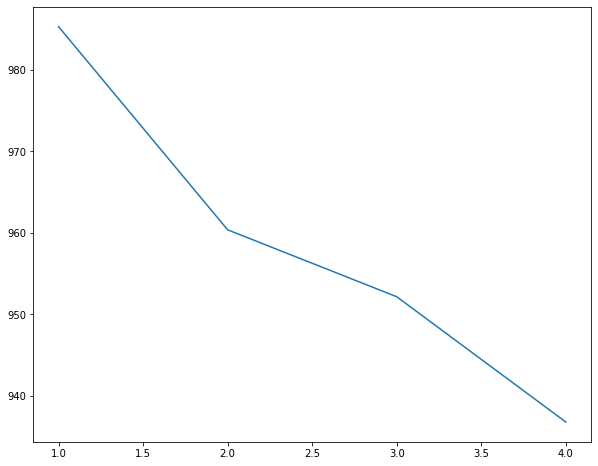

In [93]:
cluster_df = Tweets.Cluster('l', 'tfidf')

In [94]:
cluster_df['cluster'].value_counts()

0    820
1    194
Name: cluster, dtype: int64

In [95]:
cluster_df

,ability,able,aboard,absolutist,absurdly,academy,accepts,access,accomplish,account,...,владимир,путин,україна,ℏ,侘寂,本是同根生,煮豆燃豆萁,相煎何太急,豆在釜中泣,cluster
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1010,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1012,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


### LDA

In [96]:
Topics, Sent_Topic_Components = Tweets.Topic_LDA('l', 15, 15)

print(Topics[0])
print(Sent_Topic_Components[0])

(0, '0.028*"rt" + 0.026*"spacex" + 0.018*"launch" + 0.013*"tesla" + 0.011*"giga" + 0.011*"falcon" + 0.011*"team" + 0.010*"ahead" + 0.008*"well" + 0.008*"rate" + 0.008*"join" + 0.008*"come" + 0.008*"future" + 0.008*"mission" + 0.008*"year"')
[(9, 0.29964763), (14, 0.5920104)]


In [97]:
Topics

[(0,
  '0.028*"rt" + 0.026*"spacex" + 0.018*"launch" + 0.013*"tesla" + 0.011*"giga" + 0.011*"falcon" + 0.011*"team" + 0.010*"ahead" + 0.008*"well" + 0.008*"rate" + 0.008*"join" + 0.008*"come" + 0.008*"future" + 0.008*"mission" + 0.008*"year"'),
 (1,
  '0.029*"rt" + 0.021*"spacex" + 0.016*"dragon" + 0.011*"falcon" + 0.011*"support" + 0.008*"mission" + 0.008*"twitter" + 0.008*"future" + 0.008*"big" + 0.008*"new" + 0.008*"make" + 0.008*"plaid" + 0.008*"people" + 0.008*"see" + 0.005*"goodly"'),
 (2,
  '0.014*"starship" + 0.014*"spacex" + 0.011*"starlink" + 0.011*"rt" + 0.011*"twitter" + 0.009*"world" + 0.009*"ai" + 0.009*"best" + 0.009*"test" + 0.009*"happy" + 0.009*"tesla" + 0.008*"far" + 0.006*"fabiofaria" + 0.006*"defeat" + 0.006*"satellite"'),
 (3,
  '0.049*"spacex" + 0.045*"rt" + 0.020*"tesla" + 0.018*"dragon" + 0.015*"launch" + 0.015*"falcon" + 0.013*"starlink" + 0.008*"service" + 0.008*"spacecraft" + 0.008*"people" + 0.008*"liftoff" + 0.008*"amp" + 0.007*"twitter" + 0.007*"ai" + 0.0

In [98]:
Sent_Topic_Components[0]

[(9, 0.29964763), (14, 0.5920104)]

In [99]:
Topic_of_Each = []
for S in Sent_Topic_Components:
    ratios = []
    index_num = []
    l = 0
    for t in S:
        ratios.append(t[1])
        if t[1] == max(ratios):
            index_num.append(t[0])
        l = l + 1 
    topic_index = index_num[-1]
    Topic_of_Each.append(topic_index)

Topic_of_Each



[14,
 12,
 3,
 3,
 12,
 14,
 4,
 11,
 12,
 8,
 0,
 0,
 0,
 13,
 11,
 9,
 12,
 1,
 7,
 2,
 3,
 4,
 3,
 11,
 9,
 13,
 4,
 0,
 2,
 4,
 13,
 4,
 6,
 10,
 1,
 1,
 8,
 8,
 11,
 3,
 0,
 4,
 7,
 6,
 6,
 8,
 4,
 3,
 9,
 9,
 13,
 6,
 9,
 11,
 4,
 6,
 12,
 0,
 14,
 12,
 4,
 3,
 9,
 14,
 2,
 6,
 4,
 9,
 6,
 1,
 13,
 2,
 14,
 2,
 3,
 7,
 7,
 4,
 5,
 9,
 10,
 0,
 13,
 3,
 7,
 7,
 13,
 1,
 8,
 9,
 14,
 9,
 9,
 6,
 6,
 3,
 11,
 12,
 4,
 1,
 4,
 9,
 11,
 3,
 0,
 6,
 2,
 3,
 10,
 4,
 11,
 1,
 10,
 4,
 4,
 1,
 2,
 5,
 3,
 2,
 5,
 4,
 12,
 11,
 3,
 1,
 6,
 8,
 3,
 6,
 6,
 14,
 7,
 14,
 9,
 3,
 9,
 10,
 9,
 10,
 2,
 11,
 9,
 4,
 6,
 10,
 5,
 6,
 8,
 5,
 5,
 3,
 7,
 5,
 4,
 6,
 2,
 9,
 0,
 11,
 5,
 1,
 11,
 4,
 14,
 14,
 3,
 14,
 10,
 13,
 5,
 3,
 12,
 9,
 9,
 5,
 12,
 4,
 1,
 10,
 10,
 1,
 2,
 7,
 2,
 4,
 2,
 14,
 7,
 0,
 7,
 0,
 12,
 5,
 11,
 12,
 2,
 10,
 7,
 9,
 7,
 4,
 6,
 9,
 5,
 12,
 8,
 4,
 14,
 11,
 5,
 7,
 2,
 2,
 14,
 3,
 1,
 14,
 14,
 6,
 12,
 6,
 4,
 0,
 6,
 4,
 0,
 8,
 4,
 7,
 6,
 14,
 3,
 12,

In [100]:
lda_of_each = []
for T in Topic_of_Each:
    for To in Topics:
        if T == To[0]:
            lda_of_each.append(To[1])

len(lda_of_each)

1014

In [101]:
pd.DataFrame({'Date' : tweets['date'], 'Time' : tweets['time'], 'Text' : Tweet_text, 'Topic' : Topic_of_Each, 'LDA' : lda_of_each })

,Date,Time,Text,Topic,LDA
0,2022-07-15,12:55:42+00:00,"Tesla is to protect life on Earth,\nSpaceX to ...",14,"0.060*""rt"" + 0.037*""spacex"" + 0.029*""tesla"" + ..."
1,2022-07-15,12:21:05+00:00,"Mars may be a fixer upper of a planet, but it ...",12,"0.039*""tesla"" + 0.038*""spacex"" + 0.038*""rt"" + ..."
2,2022-07-15,03:54:30+00:00,RT @SpaceX: Falcon 9 launches Dragon to the @s...,3,"0.049*""spacex"" + 0.045*""rt"" + 0.020*""tesla"" + ..."
3,2022-07-15,00:42:42+00:00,Dragon launching in 2 mins,3,"0.049*""spacex"" + 0.045*""rt"" + 0.020*""tesla"" + ..."
4,2022-07-14,08:05:01+00:00,"RT @NASAKennedy: Tomorrow at 8:44pm ET, @Space...",12,"0.039*""tesla"" + 0.038*""spacex"" + 0.038*""rt"" + ..."
...,...,...,...,...,...
1009,2021-09-09,21:58:55+00:00,Tesla Model S Plaid just set official world sp...,8,"0.049*""rt"" + 0.042*""spacex"" + 0.026*""launch"" +..."
1010,2021-09-06,17:46:56+00:00,"RT @netflix: On Sept 6, you’ll meet the four c...",5,"0.020*""amp"" + 0.016*""service"" + 0.014*""rt"" + 0..."
1011,2021-09-04,04:04:40+00:00,RT @ErcXspace: Starbase 2023.\n\n#SpaceX #Star...,8,"0.049*""rt"" + 0.042*""spacex"" + 0.026*""launch"" +..."
1012,2021-09-03,08:47:10+00:00,Time is the ultimate currency,8,"0.049*""rt"" + 0.042*""spacex"" + 0.026*""launch"" +..."


### Sentiment Analysis

In [102]:
sentiment = Tweets.SA()
senti_score = sentiment['compound']

k = 0
length1 = len(senti_score)
positive = []
neutral = []
negative = []

posi_text = []
neu_text = []
neg_text = []

posi_date = []
neu_date = []
neg_date = []

posi_time = []
neu_time = []
neg_time = []

while k < length1:
    if (senti_score[k] > 0):
        positive.append(senti_score[k])
        posi_text.append(Tweet_text[k])
        posi_date.append(tweets['date'][k])
        posi_time.append(tweets['time'][k])
    elif (senti_score[k] == 0):
        neutral.append(senti_score[k])
        neu_text.append(Tweet_text[k])
        neu_date.append(tweets['date'][k])
        neu_time.append(tweets['time'][k])
    elif (senti_score[k] < 0):
        negative.append(senti_score[k])
        neg_text.append(Tweet_text[k])
        neg_date.append(tweets['date'][k])
        neg_time.append(tweets['time'][k])
    
    k = k + 1

positive_df = pd.DataFrame({'Date' : posi_date, 'Time' : posi_time, 'Text' : posi_text, 'Score' : positive})
neutral_df = pd.DataFrame({'Date' : neu_date, 'Time' : neu_time, 'Text' : neu_text, 'Score' : neutral})
negative_df = pd.DataFrame({'Date': neg_date, 'Time' : neg_time, 'Text' : neg_text, 'Score' : negative})

In [103]:
positive_df

,Date,Time,Text,Score
0,2022-07-15,12:55:42+00:00,"Tesla is to protect life on Earth,\nSpaceX to ...",0.5106
1,2022-07-15,12:21:05+00:00,"Mars may be a fixer upper of a planet, but it ...",0.7871
2,2022-07-13,15:46:57+00:00,"RT @Tesla: In Dog Mode, air conditioning will ...",0.7351
3,2022-07-13,01:23:15+00:00,Excited about @NASAWebb potential!,0.4003
4,2022-07-12,22:10:05+00:00,Oh the irony lol,0.3818
...,...,...,...,...
400,2021-09-17,18:12:05+00:00,Please add your voice to the public comments. ...,0.8953
401,2021-09-17,17:33:45+00:00,RT @SpaceX: The @Inspiration4x crew will share...,0.3182
402,2021-09-17,06:11:49+00:00,Good feedback from FSD Beta 10 users! 10.0.1 p...,0.4926
403,2021-09-16,19:51:15+00:00,Just spoke with @inspiration4x crew. All is well.,0.2732


In [104]:
neutral_df

,Date,Time,Text,Score
0,2022-07-15,03:54:30+00:00,RT @SpaceX: Falcon 9 launches Dragon to the @s...,0.0
1,2022-07-15,00:42:42+00:00,Dragon launching in 2 mins,0.0
2,2022-07-14,08:05:01+00:00,"RT @NASAKennedy: Tomorrow at 8:44pm ET, @Space...",0.0
3,2022-07-13,15:15:37+00:00,A+ for cinematography,0.0
4,2022-07-13,05:38:17+00:00,Starship launch site tonight,0.0
...,...,...,...,...
500,2021-09-09,21:58:55+00:00,Tesla Model S Plaid just set official world sp...,0.0
501,2021-09-06,17:46:56+00:00,"RT @netflix: On Sept 6, you’ll meet the four c...",0.0
502,2021-09-04,04:04:40+00:00,RT @ErcXspace: Starbase 2023.\n\n#SpaceX #Star...,0.0
503,2021-09-03,08:47:10+00:00,Time is the ultimate currency,0.0


In [105]:
negative_df

,Date,Time,Text,Score
0,2022-07-07,14:04:41+00:00,Doing my best to help the underpopulation cris...,-0.4215
1,2022-07-02,01:39:51+00:00,Feeling … perhaps … a little bored?,-0.0790
2,2022-06-18,16:52:02+00:00,We’re changing Starlink’s default wifi name to...,-0.3612
3,2022-06-18,00:57:04+00:00,Is TikTok destroying civilization? Some people...,-0.5574
4,2022-06-15,23:42:45+00:00,"I’m dressing as a sink on Halloween, as they w...",-0.1531
...,...,...,...,...
99,2021-11-19,20:23:33+00:00,RT @SpaceX: Static fire test complete – target...,-0.3400
100,2021-11-18,08:09:03+00:00,“We are choked with news and starved of histor...,-0.7717
101,2021-11-13,11:17:44+00:00,RT @SpaceX: First 6-engine static fire test of...,-0.3400
102,2021-10-22,01:02:57+00:00,RT @SpaceX: First firing of a Raptor vacuum en...,-0.3400


### LSA

In [106]:
tweet_svd = Tweets.Topic_SVD('l', 'tfidf', 15, 3)
print(tweet_svd)

[['spacex', 'rt', 'launch'], ['rt', 'spacex', 'liftoff'], ['tesla', 'team', 'amp'], ['liftoff', 'rt', 'orbit'], ['starship', 'liftoff', 'starbase'], ['land', 'stage', 'falcon'], ['land', 'starship', 'stage'], ['amp', 'starlink', 'mar'], ['nasa', 'mission', 'starlink'], ['giga', 'berlin', 'orbit'], ['good', 'mar', 'amp'], ['orbit', 'happy', 'day'], ['good', 'confirm', 'look'], ['people', 'congrats', 'confirm'], ['test', 'make', 'flight']]


## WordCloud

In [107]:
from wordcloud import WordCloud
from collections import Counter

In [108]:
Vec_count_df = Tweets.Vectorizer('l', 'count')

In [109]:
Vec_dict = dict(Vec_count_df.sum())
Vec_dict

{'ability': 4,
 'able': 4,
 'aboard': 1,
 'absolutist': 2,
 'absurdly': 2,
 'academy': 2,
 'accepts': 2,
 'access': 4,
 'accomplish': 2,
 'account': 6,
 'accurate': 2,
 'acid': 2,
 'acquire': 2,
 'acquisition': 4,
 'act': 2,
 'activate': 2,
 'activation': 2,
 'active': 4,
 'activity': 2,
 'actually': 4,
 'ad': 4,
 'add': 1,
 'addition': 2,
 'additional': 2,
 'adhere': 2,
 'adheres': 2,
 'adjust': 2,
 'advance': 1,
 'advanced': 2,
 'advent': 2,
 'affect': 2,
 'aficionado': 2,
 'africa': 2,
 'age': 4,
 'agi': 2,
 'ago': 2,
 'ahead': 11,
 'ai': 18,
 'aim': 4,
 'air': 4,
 'airborne': 2,
 'airline': 2,
 'album': 2,
 'algorithm': 8,
 'amaze': 5,
 'amazingly': 2,
 'amazon': 2,
 'american': 2,
 'amp': 81,
 'angel': 2,
 'angeles': 2,
 'angry': 2,
 'annoy': 2,
 'annoyingly': 2,
 'annual': 2,
 'antenna': 4,
 'antibody': 2,
 'anymore': 2,
 'aple': 2,
 'app': 4,
 'appear': 2,
 'apple': 2,
 'appreciate': 9,
 'approach': 2,
 'approval': 2,
 'approve': 6,
 'april': 8,
 'arceneauxhayley': 1,
 'area': 4

In [110]:
word_list = list(Vec_dict.keys())

Tags = []
for w in word_list:
    pos = get_pos(w)
    Tags.append(pos)

tag_num = 0
tag_length = len(Tags)
noun_adj_list = []
while tag_num < tag_length:
    if Tags[tag_num] in ['n', 'a']:
        noun_adj_list.append(word_list[tag_num])

    tag_num = tag_num + 1

counts = Counter(noun_adj_list)
tags = counts.most_common(40)

wc = WordCloud(background_color="white", max_font_size=60)
cloud = wc.generate_from_frequencies(dict(tags))

In [111]:
len(Tags)

1449

In [112]:
import matplotlib.pyplot as plt

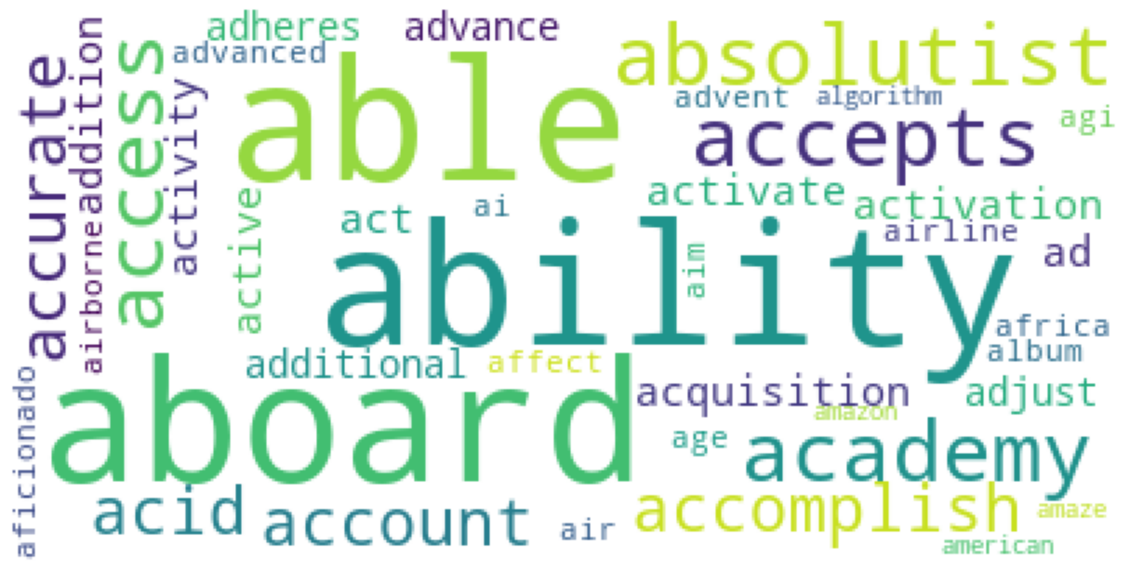

In [113]:
plt.figure(figsize=(20, 116))
plt.axis('off')
plt.imshow(cloud)
plt.show()

# Stock Data

## Importing

In [114]:
import FinanceDataReader as fdr


In [130]:
Tesla = pd.read_csv('Vehicles/TSLA.csv')
Tesla

,Date,Close,Open,High,Low,Volume,Change
0,2019-09-03,45.00,44.82,45.79,44.63,26800000.0,-0.0027
1,2019-09-04,44.14,45.38,45.69,43.84,28840000.0,-0.0191
2,2019-09-05,45.92,44.50,45.96,44.17,37020000.0,0.0403
3,2019-09-06,45.49,45.44,45.93,45.03,20950000.0,-0.0094
4,2019-09-09,46.36,46.00,46.75,45.85,24010000.0,0.0191
...,...,...,...,...,...,...,...
718,2022-07-11,703.03,756.31,759.19,700.88,33020000.0,-0.0655
719,2022-07-12,699.21,710.61,719.29,685.17,29150000.0,-0.0054
720,2022-07-13,711.12,677.21,725.91,675.12,32310000.0,0.0170
721,2022-07-14,714.94,704.70,715.91,688.08,26000000.0,0.0054


## Preprocessing stock data

In [131]:
Tesla_Open = Tesla['Open']
Tesla_Close = Tesla['Close']

In [132]:
length = len(Tesla_Open)
i = 0
Diff_per = []
while i < length:
    price_diff = Tesla_Close[i] - Tesla_Open[i]
    per_diff = price_diff/Tesla_Open[i]
    Diff_per.append(per_diff)

    i = i + 1

UpAndDown = []

for D in Diff_per:
    if D > 0:
        PNM = 'UP'
    elif D == 0:
        PNM = 'X'
    else:
        PNM = 'DOWN'
    
    UpAndDown.append(PNM)

Tesla['Diff'] = Diff_per
Tesla['Up Down'] = UpAndDown

Tesla = Tesla.reset_index()
Tesla

,index,Date,Close,Open,High,Low,Volume,Change,Diff,Up Down
0,0,2019-09-03,45.00,44.82,45.79,44.63,26800000.0,-0.0027,0.004016,UP
1,1,2019-09-04,44.14,45.38,45.69,43.84,28840000.0,-0.0191,-0.027325,DOWN
2,2,2019-09-05,45.92,44.50,45.96,44.17,37020000.0,0.0403,0.031910,UP
3,3,2019-09-06,45.49,45.44,45.93,45.03,20950000.0,-0.0094,0.001100,UP
4,4,2019-09-09,46.36,46.00,46.75,45.85,24010000.0,0.0191,0.007826,UP
...,...,...,...,...,...,...,...,...,...,...
718,718,2022-07-11,703.03,756.31,759.19,700.88,33020000.0,-0.0655,-0.070447,DOWN
719,719,2022-07-12,699.21,710.61,719.29,685.17,29150000.0,-0.0054,-0.016043,DOWN
720,720,2022-07-13,711.12,677.21,725.91,675.12,32310000.0,0.0170,0.050073,UP
721,721,2022-07-14,714.94,704.70,715.91,688.08,26000000.0,0.0054,0.014531,UP


# Combining NLP and Stock Data

## Preprocessing

In [133]:
elon_tweet_date = set(date)
elon_tweet_date

{'2021-09-02',
 '2021-09-03',
 '2021-09-04',
 '2021-09-06',
 '2021-09-09',
 '2021-09-10',
 '2021-09-11',
 '2021-09-12',
 '2021-09-13',
 '2021-09-14',
 '2021-09-15',
 '2021-09-16',
 '2021-09-17',
 '2021-09-18',
 '2021-09-21',
 '2021-09-24',
 '2021-09-25',
 '2021-09-30',
 '2021-10-01',
 '2021-10-02',
 '2021-10-04',
 '2021-10-05',
 '2021-10-07',
 '2021-10-08',
 '2021-10-09',
 '2021-10-12',
 '2021-10-14',
 '2021-10-17',
 '2021-10-20',
 '2021-10-22',
 '2021-10-23',
 '2021-10-24',
 '2021-10-25',
 '2021-10-27',
 '2021-10-28',
 '2021-10-29',
 '2021-10-30',
 '2021-11-01',
 '2021-11-02',
 '2021-11-03',
 '2021-11-06',
 '2021-11-08',
 '2021-11-09',
 '2021-11-10',
 '2021-11-11',
 '2021-11-12',
 '2021-11-13',
 '2021-11-15',
 '2021-11-17',
 '2021-11-18',
 '2021-11-19',
 '2021-11-22',
 '2021-11-23',
 '2021-11-24',
 '2021-11-25',
 '2021-11-29',
 '2021-11-30',
 '2021-12-01',
 '2021-12-02',
 '2021-12-03',
 '2021-12-04',
 '2021-12-06',
 '2021-12-08',
 '2021-12-09',
 '2021-12-10',
 '2021-12-11',
 '2021-12-

In [134]:
stock_date = list(Tesla['Date'])
only_date = []
for sd in stock_date:
    to_text = str(sd)
    date_and_time = to_text.split()
    only_date.append(date_and_time[0])

only_date

['2019-09-03',
 '2019-09-04',
 '2019-09-05',
 '2019-09-06',
 '2019-09-09',
 '2019-09-10',
 '2019-09-11',
 '2019-09-12',
 '2019-09-13',
 '2019-09-16',
 '2019-09-17',
 '2019-09-18',
 '2019-09-19',
 '2019-09-20',
 '2019-09-23',
 '2019-09-24',
 '2019-09-25',
 '2019-09-26',
 '2019-09-27',
 '2019-09-30',
 '2019-10-01',
 '2019-10-02',
 '2019-10-03',
 '2019-10-04',
 '2019-10-07',
 '2019-10-08',
 '2019-10-09',
 '2019-10-10',
 '2019-10-11',
 '2019-10-14',
 '2019-10-15',
 '2019-10-16',
 '2019-10-17',
 '2019-10-18',
 '2019-10-21',
 '2019-10-22',
 '2019-10-23',
 '2019-10-24',
 '2019-10-25',
 '2019-10-28',
 '2019-10-29',
 '2019-10-30',
 '2019-10-31',
 '2019-11-01',
 '2019-11-04',
 '2019-11-05',
 '2019-11-06',
 '2019-11-07',
 '2019-11-08',
 '2019-11-11',
 '2019-11-12',
 '2019-11-13',
 '2019-11-14',
 '2019-11-15',
 '2019-11-18',
 '2019-11-19',
 '2019-11-20',
 '2019-11-21',
 '2019-11-22',
 '2019-11-25',
 '2019-11-26',
 '2019-11-27',
 '2019-11-29',
 '2019-12-02',
 '2019-12-03',
 '2019-12-04',
 '2019-12-

In [135]:
Tesla['Date'] = only_date
Tesla

,index,Date,Close,Open,High,Low,Volume,Change,Diff,Up Down
0,0,2019-09-03,45.00,44.82,45.79,44.63,26800000.0,-0.0027,0.004016,UP
1,1,2019-09-04,44.14,45.38,45.69,43.84,28840000.0,-0.0191,-0.027325,DOWN
2,2,2019-09-05,45.92,44.50,45.96,44.17,37020000.0,0.0403,0.031910,UP
3,3,2019-09-06,45.49,45.44,45.93,45.03,20950000.0,-0.0094,0.001100,UP
4,4,2019-09-09,46.36,46.00,46.75,45.85,24010000.0,0.0191,0.007826,UP
...,...,...,...,...,...,...,...,...,...,...
718,718,2022-07-11,703.03,756.31,759.19,700.88,33020000.0,-0.0655,-0.070447,DOWN
719,719,2022-07-12,699.21,710.61,719.29,685.17,29150000.0,-0.0054,-0.016043,DOWN
720,720,2022-07-13,711.12,677.21,725.91,675.12,32310000.0,0.0170,0.050073,UP
721,721,2022-07-14,714.94,704.70,715.91,688.08,26000000.0,0.0054,0.014531,UP


## Combining TSLA data nd Tweet data

In [137]:
Tweet_senti = pd.DataFrame({'Date' : tweets['date'], 'Score' : senti_score})
Tweet_senti

,Date,Score
0,2022-07-15,0.5106
1,2022-07-15,0.7871
2,2022-07-15,0.0000
3,2022-07-15,0.0000
4,2022-07-14,0.0000
...,...,...
1009,2021-09-09,0.0000
1010,2021-09-06,0.0000
1011,2021-09-04,0.0000
1012,2021-09-03,0.0000


In [138]:
Tweet_and_Stock = Tweet_senti.groupby('Date').mean()
Tweet_and_Stock = Tweet_and_Stock.reset_index()
Tweet_and_Stock

,Date,Score
0,2021-09-02,0.000000
1,2021-09-03,0.000000
2,2021-09-04,0.000000
3,2021-09-06,0.000000
4,2021-09-09,0.000000
...,...,...
208,2022-07-11,0.449100
209,2022-07-12,0.350000
210,2022-07-13,0.283850
211,2022-07-14,0.000000


In [139]:
Tesla_for_merging = Tesla.loc[:, ['Date','Diff']]
Tesla_for_merging

,Date,Diff
0,2019-09-03,0.004016
1,2019-09-04,-0.027325
2,2019-09-05,0.031910
3,2019-09-06,0.001100
4,2019-09-09,0.007826
...,...,...
718,2022-07-11,-0.070447
719,2022-07-12,-0.016043
720,2022-07-13,0.050073
721,2022-07-14,0.014531


In [143]:
Tweet_and_Stock = pd.merge(Tweet_and_Stock, Tesla_for_merging, how = 'inner', on='Date')

In [144]:
Tweet_and_Stock

,Date,Score,Diff
0,2021-09-02,0.000000,-0.002873
1,2021-09-03,0.000000,0.001803
2,2021-09-09,0.000000,0.001925
3,2021-09-10,0.000000,-0.030714
4,2021-09-13,0.000000,0.003769
...,...,...,...
148,2022-07-11,0.449100,-0.070447
149,2022-07-12,0.350000,-0.016043
150,2022-07-13,0.283850,0.050073
151,2022-07-14,0.000000,0.014531


## Combining (TSLA+Tweet) and Vehicle Industry data

In [145]:
Vehicle_Industry_data = pd.read_csv('testing_data.csv')

In [147]:
Tweet_and_Stock = pd.merge(Tweet_and_Stock, Vehicle_Industry_data, how = 'inner', on='Date')
Tweet_and_Stock

,Date,Score,Diff,Unnamed: 0,Means,Stds
0,2021-09-02,0.000000,-0.002873,505,0.000427,0.024863
1,2021-09-03,0.000000,0.001803,506,-0.001267,0.039326
2,2021-09-09,0.000000,0.001925,509,0.016093,0.025674
3,2021-09-10,0.000000,-0.030714,510,-0.024955,0.029327
4,2021-09-13,0.000000,0.003769,511,-0.003113,0.024429
...,...,...,...,...,...,...
148,2022-07-11,0.449100,-0.070447,718,-0.024759,0.075897
149,2022-07-12,0.350000,-0.016043,719,-0.000841,0.049822
150,2022-07-13,0.283850,0.050073,720,0.012665,0.029482
151,2022-07-14,0.000000,0.014531,721,0.014151,0.048064


In [151]:
Tweet_and_Stock = Tweet_and_Stock.drop('Unnamed: 0', axis=1)
Tweet_and_Stock

,Date,Score,Diff,Means,Stds
0,2021-09-02,0.000000,-0.002873,0.000427,0.024863
1,2021-09-03,0.000000,0.001803,-0.001267,0.039326
2,2021-09-09,0.000000,0.001925,0.016093,0.025674
3,2021-09-10,0.000000,-0.030714,-0.024955,0.029327
4,2021-09-13,0.000000,0.003769,-0.003113,0.024429
...,...,...,...,...,...
148,2022-07-11,0.449100,-0.070447,-0.024759,0.075897
149,2022-07-12,0.350000,-0.016043,-0.000841,0.049822
150,2022-07-13,0.283850,0.050073,0.012665,0.029482
151,2022-07-14,0.000000,0.014531,0.014151,0.048064


In [152]:
Tweet_and_Stock.columns = ['Date', 'Tweet Sentiment Score', 'TSLA stock diff rate', 'Vehicle Industry mean', 'Vehicle Industry std']

In [153]:
Tweet_and_Stock

,Date,Tweet Sentiment Score,TSLA stock diff rate,Vehicle Industry mean,Vehicle Industry std
0,2021-09-02,0.000000,-0.002873,0.000427,0.024863
1,2021-09-03,0.000000,0.001803,-0.001267,0.039326
2,2021-09-09,0.000000,0.001925,0.016093,0.025674
3,2021-09-10,0.000000,-0.030714,-0.024955,0.029327
4,2021-09-13,0.000000,0.003769,-0.003113,0.024429
...,...,...,...,...,...
148,2022-07-11,0.449100,-0.070447,-0.024759,0.075897
149,2022-07-12,0.350000,-0.016043,-0.000841,0.049822
150,2022-07-13,0.283850,0.050073,0.012665,0.029482
151,2022-07-14,0.000000,0.014531,0.014151,0.048064


# Statistical Process

## Confidence Level 95%

In [180]:
##Confidence Level 95%

Vehicle_Industry_mean = Tweet_and_Stock['Vehicle Industry mean']
Vehicle_Industry_std = Tweet_and_Stock['Vehicle Industry std']

cl_i = 0
cl_length = len(Tweet_and_Stock['Date'])
cl_minus_list = []
cl_plus_list = []

while cl_i < cl_length:
    confidnece_factor = (1.96 * Vehicle_Industry_std[cl_i])/(45**(0.5))
    confidence_interval_minus = Vehicle_Industry_mean - confidnece_factor
    confidence_interval_plus = Vehicle_Industry_mean + confidnece_factor
    cl_minus_list.append(confidence_interval_minus)
    cl_plus_list.append(confidence_interval_plus)

    cl_i = cl_i + 1

cl_list = list(zip(confidence_interval_minus, confidence_interval_plus))

Tweet_and_Stock['Confidence Interval'] = cl_list
Tweet_and_Stock

,Date,Tweet Sentiment Score,TSLA stock diff rate,Vehicle Industry mean,Vehicle Industry std,Confidence Interval
0,2021-09-02,0.000000,-0.002873,0.000427,0.024863,"(-0.01472042616353832, 0.01557470216286232)"
1,2021-09-03,0.000000,0.001803,-0.001267,0.039326,"(-0.01641453371449672, 0.01388059461190392)"
2,2021-09-09,0.000000,0.001925,0.016093,0.025674,"(0.0009457356833047804, 0.03124086400970542)"
3,2021-09-10,0.000000,-0.030714,-0.024955,0.029327,"(-0.04010303178838342, -0.009807903461982778)"
4,2021-09-13,0.000000,0.003769,-0.003113,0.024429,"(-0.01826054256008212, 0.01203458576631852)"
...,...,...,...,...,...,...
148,2022-07-11,0.449100,-0.070447,-0.024759,0.075897,"(-0.03990607540533232, -0.009610947078931679)"
149,2022-07-12,0.350000,-0.016043,-0.000841,0.049822,"(-0.01598816944736772, 0.014306958879032921)"
150,2022-07-13,0.283850,0.050073,0.012665,0.029482,"(-0.0024821469937675207, 0.02781298133263312)"
151,2022-07-14,0.000000,0.014531,0.014151,0.048064,"(-0.0009961322616013207, 0.02929899606479932)"


## Market Influenced Fluctuation vs. Fluctuation with Non-Market Influence 

In [176]:
import numpy as np

In [185]:
yn_i = 0
yn_length = len(Tweet_and_Stock['Date'])
yn_list = []
Stock_Fluct = Tweet_and_Stock['TSLA stock diff rate']

while yn_i < yn_length:
    if (cl_list[yn_i][0] <= Stock_Fluct[yn_i]) and (Stock_Fluct[yn_i] <= cl_list[yn_i][1]):
        yn_list.append('N')
    else:
        yn_list.append('Y')
    
    yn_i = yn_i + 1

Tweet_and_Stock['Non-market influence'] = yn_list
Tweet_and_Stock
    

,Date,Tweet Sentiment Score,TSLA stock diff rate,Vehicle Industry mean,Vehicle Industry std,Confidence Interval,Non-market influence
0,2021-09-02,0.000000,-0.002873,0.000427,0.024863,"(-0.01472042616353832, 0.01557470216286232)",N
1,2021-09-03,0.000000,0.001803,-0.001267,0.039326,"(-0.01641453371449672, 0.01388059461190392)",N
2,2021-09-09,0.000000,0.001925,0.016093,0.025674,"(0.0009457356833047804, 0.03124086400970542)",N
3,2021-09-10,0.000000,-0.030714,-0.024955,0.029327,"(-0.04010303178838342, -0.009807903461982778)",N
4,2021-09-13,0.000000,0.003769,-0.003113,0.024429,"(-0.01826054256008212, 0.01203458576631852)",N
...,...,...,...,...,...,...,...
148,2022-07-11,0.449100,-0.070447,-0.024759,0.075897,"(-0.03990607540533232, -0.009610947078931679)",Y
149,2022-07-12,0.350000,-0.016043,-0.000841,0.049822,"(-0.01598816944736772, 0.014306958879032921)",Y
150,2022-07-13,0.283850,0.050073,0.012665,0.029482,"(-0.0024821469937675207, 0.02781298133263312)",Y
151,2022-07-14,0.000000,0.014531,0.014151,0.048064,"(-0.0009961322616013207, 0.02929899606479932)",N


In [188]:
Tweet_and_Stock['Non-market influence'].value_counts()

Y    85
N    68
Name: Non-market influence, dtype: int64

In [200]:
Q_market_influence = Tweet_and_Stock.groupby('Non-market influence')
non_market_influence = Q_market_influence.get_group('Y')
only_market_influence = Q_market_influence.get_group('N')

In [201]:
non_market_influence

,Date,Tweet Sentiment Score,TSLA stock diff rate,Vehicle Industry mean,Vehicle Industry std,Confidence Interval,Non-market influence
5,2021-09-14,0.000000,0.002586,-0.022091,0.020789,"(-0.03723883595557092, -0.006943707629170279)",Y
10,2021-09-24,0.000000,0.038209,0.006485,0.043397,"(-0.00866259699797472, 0.021632531328425922)",Y
20,2021-10-22,-0.170000,0.015835,-0.015317,0.024564,"(-0.030464953176242718, -0.00016982484984207936)",Y
21,2021-10-25,0.000000,0.078198,0.023521,0.040173,"(0.00837383727880718, 0.03866896560520782)",Y
23,2021-10-28,0.000000,0.008172,0.046475,0.063837,"(0.031327148286941886, 0.06162227661334252)",Y
...,...,...,...,...,...,...,...
143,2022-06-15,0.136800,0.054696,0.015872,0.037623,"(0.000724780254072379, 0.03101990858047302)",Y
146,2022-07-06,0.148633,0.004131,-0.013139,0.031918,"(-0.02828669819189732, 0.0020084301345033202)",Y
148,2022-07-11,0.449100,-0.070447,-0.024759,0.075897,"(-0.03990607540533232, -0.009610947078931679)",Y
149,2022-07-12,0.350000,-0.016043,-0.000841,0.049822,"(-0.01598816944736772, 0.014306958879032921)",Y


In [202]:
only_market_influence

,Date,Tweet Sentiment Score,TSLA stock diff rate,Vehicle Industry mean,Vehicle Industry std,Confidence Interval,Non-market influence
0,2021-09-02,0.000000,-0.002873,0.000427,0.024863,"(-0.01472042616353832, 0.01557470216286232)",N
1,2021-09-03,0.000000,0.001803,-0.001267,0.039326,"(-0.01641453371449672, 0.01388059461190392)",N
2,2021-09-09,0.000000,0.001925,0.016093,0.025674,"(0.0009457356833047804, 0.03124086400970542)",N
3,2021-09-10,0.000000,-0.030714,-0.024955,0.029327,"(-0.04010303178838342, -0.009807903461982778)",N
4,2021-09-13,0.000000,0.003769,-0.003113,0.024429,"(-0.01826054256008212, 0.01203458576631852)",N
...,...,...,...,...,...,...,...
144,2022-06-17,0.270733,0.015586,0.024001,0.046365,"(0.008853735863187679, 0.03914886418958832)",N
145,2022-07-05,0.220200,0.045142,0.038746,0.081413,"(0.023598605547828982, 0.05389373387422962)",N
147,2022-07-07,0.139522,0.045414,0.034896,0.042736,"(0.019748349441744282, 0.050043477768144926)",N
151,2022-07-14,0.000000,0.014531,0.014151,0.048064,"(-0.0009961322616013207, 0.02929899606479932)",N


## Collecting Data of incidents that happened on Non-Market Influenced date

In [205]:
singularity_date = list(non_market_influence['Date'])
print(singularity_date)

['2021-09-14', '2021-09-24', '2021-10-22', '2021-10-25', '2021-10-28', '2021-10-29', '2021-11-01', '2021-11-02', '2021-11-03', '2021-11-09', '2021-11-10', '2021-11-11', '2021-11-15', '2021-11-17', '2021-11-18', '2021-11-19', '2021-11-23', '2021-11-24', '2021-11-29', '2021-12-02', '2021-12-03', '2021-12-09', '2021-12-10', '2021-12-14', '2021-12-22', '2021-12-23', '2021-12-27', '2022-01-07', '2022-01-10', '2022-01-12', '2022-01-13', '2022-01-14', '2022-01-18', '2022-01-20', '2022-01-21', '2022-01-26', '2022-01-27', '2022-01-28', '2022-02-01', '2022-02-02', '2022-02-03', '2022-02-09', '2022-02-11', '2022-02-14', '2022-02-17', '2022-02-18', '2022-02-25', '2022-03-07', '2022-03-15', '2022-03-22', '2022-03-25', '2022-03-28', '2022-04-01', '2022-04-04', '2022-04-06', '2022-04-07', '2022-04-14', '2022-04-18', '2022-04-19', '2022-04-20', '2022-04-22', '2022-04-25', '2022-04-26', '2022-04-28', '2022-04-29', '2022-05-02', '2022-05-04', '2022-05-05', '2022-05-11', '2022-05-13', '2022-05-18', '2022

In [294]:
incident = ["Tesla's Co-Founder building battery start-up", "Tesla's autopilot upgraded", 'X', 'X', 'Hertz orders 100,000 Tesla Model3', 'X', 'X', 'Recall for nearly 12,000 vehicles', "Tesla's latest patch hints at cloud-synced driver profiles", 'Twitter', 'Twitter', 'Twitter', 'Serious Phantom Breaking problem in Autopilot', 'Tesla embraces cobalt-free battery', 'X', "Tesla's factory worker alleges sexual harassment", "X", "Elon Musk sold another $1billion Tesla Shares", "Elon Musk urges employees to focus on minimizing cost of deliveries", "Tesla seeking for tariff waiver for graphite from China for batteries", "X", "Musk sells another 934091 shares worth $963.2million", "Twitter", "Telsa to accept dogecoin as payment for merchandise", "X", "Elon Musk blows up his Model X that needed over $22000 battery replacement", "X", "X", "Tesla Strikes Battery-Metal Deal", "X", "Cybertruk production Delay Rumor", "Twitter", "X", "X", "X", "Musk says Tesla will not produce a new vehicle model in 2022", "Tesla not producing a new vehicle model in 2022", "X", "Tesla recalls nearly 54000 vehicles that may disobey stop signs", "X", "Tesla build updates Supercharger map & applies to build giant new cathode factory for battery", "X", "X", "X", "Elon Musk accuese SEC of calculated effor to chill his right to free speech", "Tesla announces it has prouced 1 million nest-gen 4680 battery cell at its pilot factory in California", "X", "Berlin 'Gigafactory' approval", "Car price raise", "Elon musk dances as he opens new Tesla factory in Germany", "X", "Tesla announces another stock split", "X", "X", "No more radar fo r Tesla EVs headed for Europe", "Tesla's Giga Fest as Giga Texas", "Elon Musk offers to buy Twitter", "Elon Musk Sued for false tweet on 2018", "X", "Tesla performance announceent", "X", "Twitter", "Musk buys Twitter", "X", "Musk sold more than $8 billion in Tesla stock", "X", "Tesla to expand Shanghai factory to become the largest automotive export hub in the world", "Bill Gates hits back at Elon Musk", "Huge delay on Shanghi plant", "Elon Musk says Twitter deal temporarily on hold", "Tesla cut from S&P 500 ESG Index", "X", "X", "Tesla updates car software", "Tesla moves to expand Gigafactory Berlin", "X", "X", "Elon Musk plans to cut 10% of Tesla jobs", "X", "X", "X", "X", "X", "Tesla to lay off 229 employees, Shuts San Mateo office", "Tesla loses its head of AI and Vision Andrei Karpathuy"]

In [295]:
len(incident)

85

In [296]:
non_market_influence['Incidents'] = incident
non_market_influence

/var/folders/3m/s0ysqyzs3fb_mcgvm4wjzt3w0000gn/T/ipykernel_85062/856289462.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_market_influence['Incidents'] = incident


,Date,Tweet Sentiment Score,TSLA stock diff rate,Vehicle Industry mean,Vehicle Industry std,Confidence Interval,Non-market influence,Incidents
5,2021-09-14,0.000000,0.002586,-0.022091,0.020789,"(-0.03723883595557092, -0.006943707629170279)",Y,Tesla's Co-Founder building battery start-up
10,2021-09-24,0.000000,0.038209,0.006485,0.043397,"(-0.00866259699797472, 0.021632531328425922)",Y,Tesla's autopilot upgraded
20,2021-10-22,-0.170000,0.015835,-0.015317,0.024564,"(-0.030464953176242718, -0.00016982484984207936)",Y,X
21,2021-10-25,0.000000,0.078198,0.023521,0.040173,"(0.00837383727880718, 0.03866896560520782)",Y,X
23,2021-10-28,0.000000,0.008172,0.046475,0.063837,"(0.031327148286941886, 0.06162227661334252)",Y,"Hertz orders 100,000 Tesla Model3"
...,...,...,...,...,...,...,...,...
143,2022-06-15,0.136800,0.054696,0.015872,0.037623,"(0.000724780254072379, 0.03101990858047302)",Y,X
146,2022-07-06,0.148633,0.004131,-0.013139,0.031918,"(-0.02828669819189732, 0.0020084301345033202)",Y,X
148,2022-07-11,0.449100,-0.070447,-0.024759,0.075897,"(-0.03990607540533232, -0.009610947078931679)",Y,X
149,2022-07-12,0.350000,-0.016043,-0.000841,0.049822,"(-0.01598816944736772, 0.014306958879032921)",Y,"Tesla to lay off 229 employees, Shuts San Mate..."


In [305]:
dividing_non_market_risk = non_market_influence.groupby('Incidents')
No_incident = dividing_non_market_risk.get_group('X')
By_Twitter = dividing_non_market_risk.get_group('Twitter')

No_incident

,Date,Tweet Sentiment Score,TSLA stock diff rate,Vehicle Industry mean,Vehicle Industry std,Confidence Interval,Non-market influence,Incidents
20,2021-10-22,-0.170000,0.015835,-0.015317,0.024564,"(-0.030464953176242718, -0.00016982484984207936)",Y,X
21,2021-10-25,0.000000,0.078198,0.023521,0.040173,"(0.00837383727880718, 0.03866896560520782)",Y,X
24,2021-10-29,0.359200,0.029708,0.000924,0.023981,"(-0.01422379836878412, 0.01607132995761652)",Y,X
25,2021-11-01,0.285950,0.055537,0.018993,0.077121,"(0.003845560079922379, 0.03414068840632302)",Y,X
35,2021-11-18,-0.385850,-0.009191,-0.032487,0.064346,"(-0.04763476315066842, -0.017339634824267782)",Y,X
38,2021-11-23,0.440400,-0.050090,-0.029182,0.041279,"(-0.04432913923077442, -0.01403401090437378)",Y,X
44,2021-12-03,0.000000,-0.064363,-0.037496,0.051426,"(-0.05264406385040482, -0.022348935524004177)",Y,X
54,2021-12-22,0.112000,0.044747,0.014648,0.037763,"(-0.0004998630129977207, 0.02979526531340292)",Y,X
56,2021-12-27,0.361200,0.018879,-0.006093,0.042903,"(-0.02124037210472742, 0.00905475622167322)",Y,X
59,2022-01-07,0.000000,-0.049437,0.000614,0.048081,"(-0.01453384543857072, 0.01576128288782992)",Y,X


In [303]:
By_Twitter

,Date,Tweet Sentiment Score,TSLA stock diff rate,Vehicle Industry mean,Vehicle Industry std,Confidence Interval,Non-market influence,Incidents
29,2021-11-09,0.00000,-0.127897,-0.052509,0.093851,"(-0.06765667360203231, -0.03736154527563168)",Y,Twitter
30,2021-11-10,0.00000,0.056947,-0.023989,0.073657,"(-0.03913660020602962, -0.00884147187962898)",Y,Twitter
31,2021-11-11,0.00000,-0.035601,0.014632,0.036642,"(-0.0005157414426737207, 0.02977938688372692)",Y,Twitter
48,2021-12-10,0.34045,0.008208,-0.010066,0.024400,"(-0.02521320672573242, 0.00508192160066822)",Y,Twitter
63,2022-01-14,0.00000,0.029150,0.010497,0.032676,"(-0.00465023993393722, 0.02564488839246342)",Y,Twitter
112,2022-04-25,0.12222,0.019459,0.087493,0.445956,"(0.07234587336244208, 0.10264100168884271)",Y,Twitter


In [306]:
print(len(No_incident))
print(len(By_Twitter))

36
6


In [1]:
incident = ["Tesla's Co-Founder building battery start-up", "Tesla's autopilot upgraded", 'X', 'X', 'Hertz orders 100,000 Tesla Model3', 'X', 'X', 'Recall for nearly 12,000 vehicles', "Tesla's latest patch hints at cloud-synced driver profiles", 'Twitter', 'Twitter', 'Twitter', 'Serious Phantom Breaking problem in Autopilot', 'Tesla embraces cobalt-free battery', 'X', "Tesla's factory worker alleges sexual harassment", "X", "Elon Musk sold another $1billion Tesla Shares", "Elon Musk urges employees to focus on minimizing cost of deliveries", "Tesla seeking for tariff waiver for graphite from China for batteries", "X", "Musk sells another 934091 shares worth $963.2million", "Twitter", "Telsa to accept dogecoin as payment for merchandise", "X", "Elon Musk blows up his Model X that needed over $22000 battery replacement", "X", "X", "Tesla Strikes Battery-Metal Deal", "X", "Cybertruk production Delay Rumor", "Twitter", "X", "X", "X", "Musk says Tesla will not produce a new vehicle model in 2022", "Tesla not producing a new vehicle model in 2022", "X", "Tesla recalls nearly 54000 vehicles that may disobey stop signs", "X", "Tesla build updates Supercharger map & applies to build giant new cathode factory for battery", "X", "X", "X", "Elon Musk accuese SEC of calculated effor to chill his right to free speech", "Tesla announces it has prouced 1 million nest-gen 4680 battery cell at its pilot factory in California", "X", "Berlin 'Gigafactory' approval", "Car price raise", "Elon musk dances as he opens new Tesla factory in Germany", "X", "Tesla announces another stock split", "X", "X", "No more radar fo r Tesla EVs headed for Europe", "Tesla's Giga Fest as Giga Texas", "Elon Musk offers to buy Twitter", "Elon Musk Sued for false tweet on 2018", "X", "Tesla performance announceent", "X", "Twitter", "Musk buys Twitter", "X", "Musk sold more than $8 billion in Tesla stock", "X", "Tesla to expand Shanghai factory to become the largest automotive export hub in the world", "Bill Gates hits back at Elon Musk", "Huge delay on Shanghi plant", "Elon Musk says Twitter deal temporarily on hold", "Tesla cut from S&P 500 ESG Index", "X", "X", "Tesla updates car software", "Tesla moves to expand Gigafactory Berlin", "X", "X", "Elon Musk plans to cut 10% of Tesla jobs", "X", "X", "X", "X", "X", "Tesla to lay off 229 employees, Shuts San Mateo office", "Tesla loses its head of AI and Vision Andrei Karpathuy"]

In [2]:
incident

["Tesla's Co-Founder building battery start-up",
 "Tesla's autopilot upgraded",
 'X',
 'X',
 'Hertz orders 100,000 Tesla Model3',
 'X',
 'X',
 'Recall for nearly 12,000 vehicles',
 "Tesla's latest patch hints at cloud-synced driver profiles",
 'Twitter',
 'Twitter',
 'Twitter',
 'Serious Phantom Breaking problem in Autopilot',
 'Tesla embraces cobalt-free battery',
 'X',
 "Tesla's factory worker alleges sexual harassment",
 'X',
 'Elon Musk sold another $1billion Tesla Shares',
 'Elon Musk urges employees to focus on minimizing cost of deliveries',
 'Tesla seeking for tariff waiver for graphite from China for batteries',
 'X',
 'Musk sells another 934091 shares worth $963.2million',
 'Twitter',
 'Telsa to accept dogecoin as payment for merchandise',
 'X',
 'Elon Musk blows up his Model X that needed over $22000 battery replacement',
 'X',
 'X',
 'Tesla Strikes Battery-Metal Deal',
 'X',
 'Cybertruk production Delay Rumor',
 'Twitter',
 'X',
 'X',
 'X',
 'Musk says Tesla will not produc

In [ ]:
2021-11-18 : 2.3% up 후 0.9% down
2022-01-28 : 이틀간 -1.5%, -11.1% 후 1.28% up


In [4]:
import pandas as pd

In [5]:
pd.read_csv('Vehicles/TSLA.csv')

,Date,Close,Open,High,Low,Volume,Change
0,2019-09-03,45.00,44.82,45.79,44.63,26800000.0,-0.0027
1,2019-09-04,44.14,45.38,45.69,43.84,28840000.0,-0.0191
2,2019-09-05,45.92,44.50,45.96,44.17,37020000.0,0.0403
3,2019-09-06,45.49,45.44,45.93,45.03,20950000.0,-0.0094
4,2019-09-09,46.36,46.00,46.75,45.85,24010000.0,0.0191
...,...,...,...,...,...,...,...
718,2022-07-11,703.03,756.31,759.19,700.88,33020000.0,-0.0655
719,2022-07-12,699.21,710.61,719.29,685.17,29150000.0,-0.0054
720,2022-07-13,711.12,677.21,725.91,675.12,32310000.0,0.0170
721,2022-07-14,714.94,704.70,715.91,688.08,26000000.0,0.0054
